In [49]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from datetime import datetime

tf.random.set_seed(455)
np.random.seed(455)

ticker = "AAPL"
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download(ticker, start, end)
dataset

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-06-28,23.225000,23.415001,23.035000,23.397499,21.604422,161779600
2016-06-29,23.492500,23.637501,23.407499,23.600000,21.791401,146124000
2016-06-30,23.610001,23.942499,23.575001,23.900000,22.068407,143345600
2016-07-01,23.872499,24.117500,23.832500,23.972500,22.135351,104106000
2016-07-05,23.847500,23.850000,23.615000,23.747499,21.927595,110820800
...,...,...,...,...,...,...
2023-06-21,184.899994,185.410004,182.589996,183.960007,183.960007,49515700
2023-06-22,183.740005,187.050003,183.669998,187.000000,187.000000,51245300
2023-06-23,185.550003,187.559998,185.009995,186.679993,186.679993,53079300


In [50]:
# Preprocess the data
data = dataset['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Function to create sequences for LSTM and GRU models
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 20

# Create sequences for LSTM and GRU models
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

RMSE: 0.11957542698911944


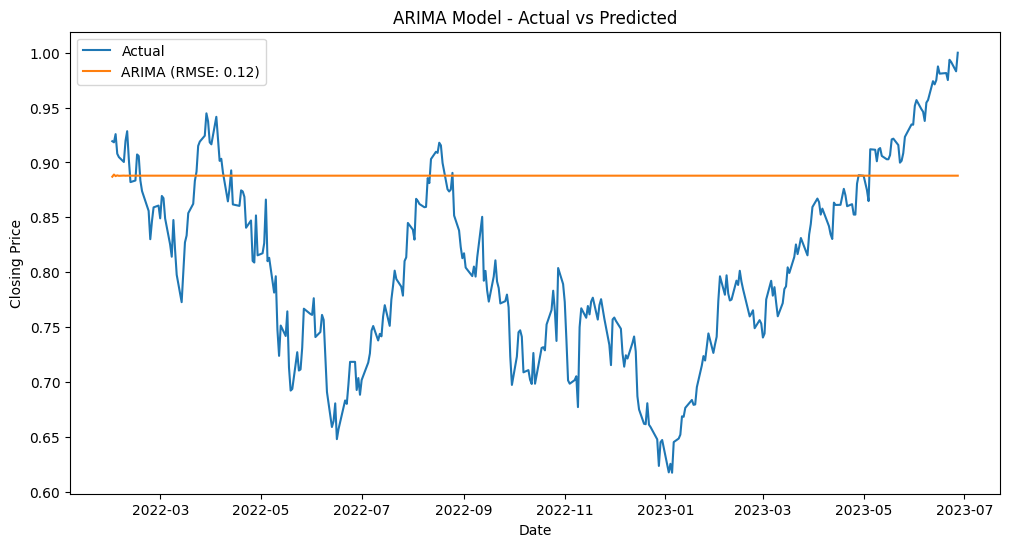

In [56]:
# Fit the ARIMA model
model = ARIMA(train_data, order=(2, 1, 2))  # Replace the order values with the appropriate ones for your data
model_fit = model.fit()

# Make predictions
arima_predictions = model_fit.predict(start=train_size, end=len(data)-1, typ='levels')

# Calculate RMSE
arima_rmse = np.sqrt(mean_squared_error(test_data, arima_predictions))
print(f"RMSE: {arima_rmse}")

# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(dataset.index[train_size:], test_data, label='Actual')
plt.plot(dataset.index[train_size:], arima_predictions, label=f'ARIMA (RMSE: {arima_rmse:.2f})')
plt.title('ARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


11/11 [==============================] - 0s 2ms/step
RMSE: 3.7287878123791747


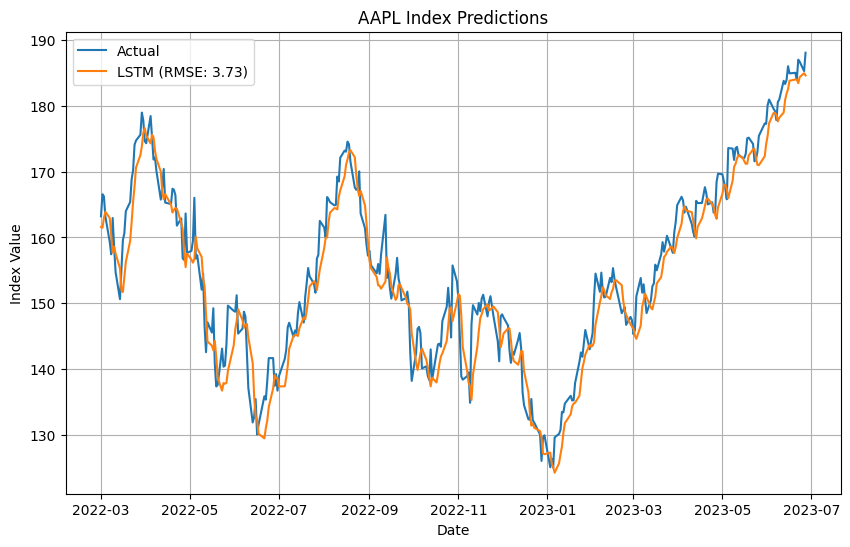

In [52]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Generate predictions for the LSTM model
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))

# Calculate RMSE for each model
lstm_rmse = np.sqrt(mean_squared_error(data[train_size+sequence_length:], lstm_predictions))
print(f"RMSE: {lstm_rmse}")

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(dataset.index[train_size+sequence_length:], data[train_size+sequence_length:], label='Actual')
plt.plot(dataset.index[train_size+sequence_length:], lstm_predictions, label=f'LSTM (RMSE: {lstm_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title(f'{ticker} Index Predictions')
plt.legend()
plt.grid(True)
plt.show()


11/11 [==============================] - 0s 2ms/step
RMSE: 3.1910227517908414


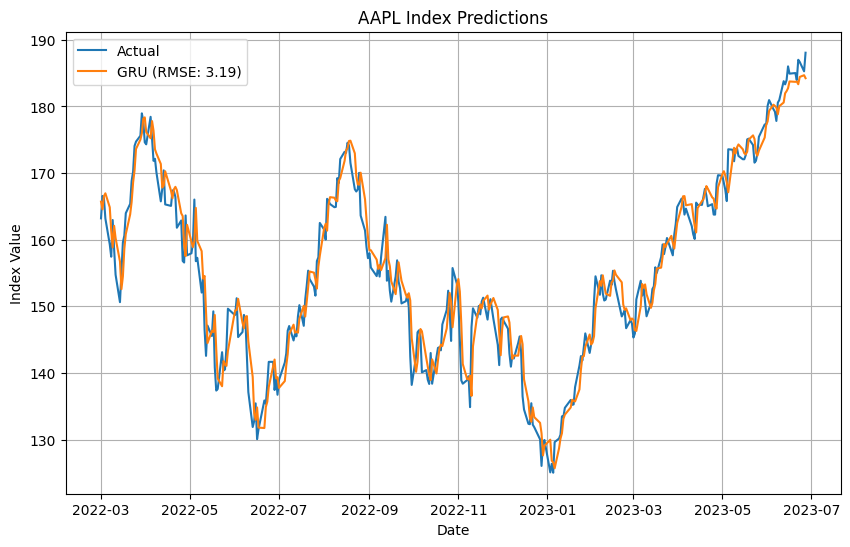

In [53]:
# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(50, activation='relu', input_shape=(sequence_length, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the GRU model
gru_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Generate predictions for the GRU model
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions.reshape(-1, 1))

# Calculate RMSE for each model
gru_rmse = np.sqrt(mean_squared_error(data[train_size+sequence_length:], gru_predictions))
print(f"RMSE: {gru_rmse}")

# Plot the predictions
plt.figure(figsize=(10, 6))
plt.plot(dataset.index[train_size+sequence_length:], data[train_size+sequence_length:], label='Actual')
plt.plot(dataset.index[train_size+sequence_length:], gru_predictions, label=f'GRU (RMSE: {gru_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title(f'{ticker} Index Predictions')
plt.legend()
plt.grid(True)
plt.show()
